# Algorithme génétique pour le problème du max-one

*nicolas.bredeche(at)upmc.fr*

Mise à jour: 
* 2017-03-20 - première version (avec A. Pajot et P. Ecoffet)
* 2018-03-29 - ajout d'une représentation graphique, découpage en cellule
* 2020-12-06 - passage en Python 3.x
* 2020-12-10 - révision majeure MU4RBI04

<!--`print()`-->

---

Ce notebook décrit un algorithme génétique basique, qui est illustré sur le problème classique du *max-one*. 

La première partie définit les fonctions utiles pour l'algorithme, et se conclut par une cellule contenant un "**Exemple introductif**" qui montre comment l'utiliser. 

La seconde partie contient les questions à répondre. Il s'agit dans un premier temps d'utiliser l'algorithme définit auparavant en changeant ses paramètres. Dans un second temps, vous devrez ajouter des opérateurs (de sélection, de variation). Enfin, il s'agira d'aborder un nouveau problème, qui demande de réflechir à la structure du génome et sa conséquence sur les opérateurs. 

Pour finir, on abordera un problème important des algorithmes évolutionnaire: la stochasticité, qui implique de faire plusieurs exécutions indépendantes et d'en compiler les résultats pour avoir une bonne estimation en moyenne de la performance de nos algorithmes.

---

# Initialisation et défitions de fonctions d'affichage

Remarque: *il n'est pas nécessaire d'étudier le code de cette partie (importation des librairies et définition de fonction pour l'affichage)*

In [2]:
#%matplotlib inline
#%load_ext Cython

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import operator
import copy

import os
from datetime import datetime
from datetime import date

#import seaborn as sns
#sns.set()

from random import random, randint, sample
from random import *

from statistics import median 

print(date.today(), datetime.now().strftime("%H:%M:%S"),"GMT") # timestamp is greenwich time
print("OK.")

2021-11-25 15:58:02 GMT
OK.


In [3]:
# Graph-related functions

def plot(ax,x,y,xMin,xMax,yMin,yMax):
    colors = "red" #np.random.rand(len(x))
    area = np.pi * (5 * np.ones(1))**2
    ax.set_xlim(xMin, xMax)
    ax.set_ylim(yMin, yMax)
    ax.scatter( np.asarray(x), np.asarray(y), s=area, c=colors, alpha=0.5)
    ax.set_xlabel('Evaluations')
    ax.set_ylabel('Performances')
    #plt.show()
    
def plotIndividuals(ax,datapop,xMin=0,xMax=1,yMin=0,yMax=1):
    xCoord = []
    yCoord = []
    
    for e in datapop:
        xCoord.append(e[0])
        yCoord.append(e[1])
    
    plot(ax,xCoord,yCoord,xMin,xMax,yMin,yMax)

print(date.today(), datetime.now().strftime("%H:%M:%S"),"GMT") # timestamp is greenwich time
print("OK.")

2021-11-25 15:58:04 GMT
OK.


---

# Algorithme génétique : fonction objectif pour le problème du *max-one*

Nous définissons ici le **problème du max-one**, pour lequel le score (=la fitness) est d'autant plus élevé que le nombre de bits dans le génome vaut 1. 

**Données du problème**
* **représentation**: le génome d'un individu est défini comme une suite finie de 0 et de 1 (i.e. *n* valeurs binaires)
* **objectif**: la solution optimale est atteinte lorsque le génome d'un individu est uniquement constitué de 1
* **calcul de la fitness**: distance de Hamming entre la solution candidate et la solution optimale (ici: l'objectif est artificiellement fixé comme une suite de 1)

Il s'agit là d'un problème *jouet* très utilisé pour étudier la dynamique de l'optimisation.


In [4]:
# renvoie la fitness d'un individu pour le problème max-one
def evaluate_oneMaxProblem(genome):
    fitness = 0
    for e in genome:
        if e == 1:
            fitness = fitness + 1
    return fitness

print(date.today(), datetime.now().strftime("%H:%M:%S"),"GMT") # timestamp is greenwich time
print("OK.")

2021-11-25 15:58:06 GMT
OK.


# Algorithme génétique : opérateurs


On suivra la convention suivante pour les structures de données: 
*   un *individu* est un tableau qui comprend dans sa première case un *génome* (ici: une suite de valeurs binaires) et dans sa seconde case une *fitness* (c'est à dire son score, à calculer en fonction du problème à résoudre).
*   une *population* est une liste qui contient des *individus*

On définit dans la cellule qui suit:

*   un opérateur de mutation (bitflip mutation)
*   un opérateur de sélection (tournament selection, de taille *k*)
*   une fonction qui renvoie le meilleur individu d'une population


In [5]:
# renvoie une copie mutée de l'individu passé en paramètre, selon la méthode de mutation "bit-flip"
def mutateBitFlip(individu,pMutation):
    nouvelIndividu = []
    for e in individu:
        if random() < pMutation:
            nouvelIndividu.append( (e + 1) % 2 )
        else:
            nouvelIndividu.append( e )
    return nouvelIndividu

# renvoie un individu sélectionné selon méthode du tournoi (de taille k)
def selectTournament(pop,k):
    # sélectionne K individus (au hasard) pour le tournoi
    tournoi = sample(list(range(len(pop))),k) # renvoi les index de K individus parmis N
    # sélectionne le meilleur parmis les K individus (classe par ordre croissant, renvoi le dernier élément selon le fitness)
    parent = pop[ sorted(tournoi, key=lambda x:pop[x][1])[-1] ][0]
    return parent

# renvoie le meilleu individu de la population passée en paramètre
def returnBestIndividual(pop):
    meilleureFitness = 0
    meilleurGenome = []
    for individu in pop:
        if individu[1] > meilleureFitness:
            meilleureFitness = individu[1]
            meilleurGenome = individu[0]
    return [meilleurGenome,meilleureFitness]

print(date.today(), datetime.now().strftime("%H:%M:%S"),"GMT") # timestamp is greenwich time
print("OK.")

2021-11-25 15:58:08 GMT
OK.


# Algorithme génétique: boucle d'évolution (fonction principale)

La fonction *evolve* décrit la boucle principale de l'algorithme génétique. Elle est générique, dans le sens ou on doit lui fournir l'opérateur de sélection de parent, l'opérateur de mutation et l'opérateur d'évaluation. 

Etudiez son fonctionnement. Nous l'utiliserons dans la cellule suivante.

Remarque: la variable *verbose* permet d'afficher plus (si True) ou moins (si False) de détails. *italicized text*

In [6]:
#
# Boucle principale de l'algorithme génétique
#

def evolve(pop,evals,taillePop,evaluate,select,mutate,pMutation,verbose=False):
  it = 0
  nbGen = 0
  data = []

  meilleurIndividuDepuisToujours = [[],0]

  while it + taillePop <= evals:

      if verbose == True:
          print ("# Generation", nbGen,":",)

      # évalue les individus

      for individu in pop:
          individu[1] = evaluate(individu[0])

      # mémorise le meilleur de la génération
      meilleurIndividu = returnBestIndividual(pop)
      data.append([it+taillePop,meilleurIndividu[1]])

      # met à jour, si nécessaire, le meilleur individu depuis le début
      if meilleurIndividu[1] > meilleurIndividuDepuisToujours[1]:
        meilleurIndividuDepuisToujours = meilleurIndividu[:]
        meilleurIteration = it # donne l'itération correspondant au début de la génération courante.

      if verbose == True:
        print ("\tMeilleur individu courant:",meilleurIndividu[0]," -- fitness:",meilleurIndividu[1])

      # construit une nouvelle population

      nouvellePopulation = []

      for i in range(taillePop):

          parent = select(pop,tailleTournoi)

          # crée un nouvel individu par mutation de l'individu parent, et ajoute à la nouvelle population
          nouvelIndividu = mutate(parent,pMutation)

          #print ("\tParent:", parent)
          #print ("\tchild :",nouvelIndividu) 

          nouvellePopulation.append([nouvelIndividu,0])

      # passe a la génération suivante

      pop = nouvellePopulation[:]

      it = it + taillePop
      nbGen += 1

  return (data,meilleurIndividuDepuisToujours,meilleurIteration)

print(date.today(), datetime.now().strftime("%H:%M:%S"),"GMT") # timestamp is greenwich time
print("OK.")

2021-11-25 15:58:11 GMT
OK.


# Exemple introductif: optimisation sur le problème max-one

Nous allons utiliser un algorithme génétique simple pour résoudre le problème du max-one.

L'algorithme génétique que nous utilisons est défini comme suit:

* **représentation**: le *génome* d'un individu est représenté par une suite de bits (0 ou 1). 
* **opérateurs**: nous utilisons une sélection par tournoi et un seul opérateur de variation: la mutation "bit-flip" vue en cours.



Meilleure genome     : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Meilleure fitness    : 99
trouvé à l'itération : 890


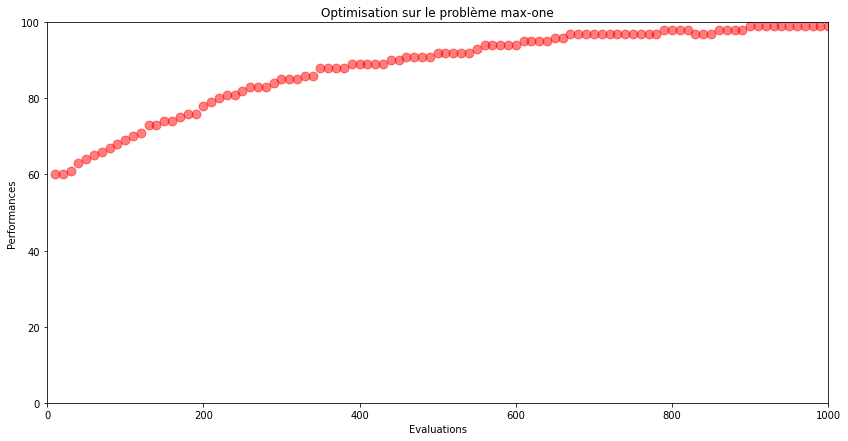

In [7]:
# paramètres 

evaluations = 1000
tailleInd = 100
taillePop = 10
tailleTournoi = 8
Pmutation = 1./tailleInd
verbose = False

# initialisation des individus de la population initiale

population = []
for i in range(taillePop):
    individu = []
    for j in range(tailleInd):
        individu.append( randint(0,1) )
    population.append([individu,0]) # N * [ genome[] , fitness ]

# exécute l'algorithme génétique

retValue = evolve(population,evaluations,taillePop,evaluate_oneMaxProblem,selectTournament,mutateBitFlip,Pmutation,verbose)

# affichage des résultats 
fig, ax = plt.subplots(figsize=(14,7))
ax.set_title('Optimisation sur le problème max-one')
plotIndividuals(ax,retValue[0],0,evaluations,0,tailleInd)
fig.show

print ("Meilleure genome     :", retValue[1][0])
print ("Meilleure fitness    :", retValue[1][1])
print ("trouvé à l'itération :", retValue[2])



---
---
# TRAVAUX PRATIQUES

Préambule: *vous devez répondre à cette question et aux suivantes dans les cellules qui les suivent -- **ne modifiez pas** les cellules précédentes. Vous allez réutiliser certaines fonctions définies précédemment, et vous pourrez vous inspirer du code ci-dessus pour répondre aux questions.*

Chaque exercice doit être indépendant. C'est à dire que pour chaque exercice, vous réinitialiserez les valeurs des paramètres à celle définies dans l'exemple ci-dessus, sauf si cela est explicitement demandé.




---



# Exercice 1

Etudiez le comportement de l'algorithme lorsque l'on change la taille de la population, pour un même nombre d'évaluations au total. 

Affichez les résultats pour trois paramètrages "typiques" (uniquement le graphe et la valeur du meilleur individu, comme ci-dessus).

Qu'en concluez-vous?


Taille de la population : 8  Meilleure fitness    : 98  trouvé à l'itération : 576
Taille de la population : 20  Meilleure fitness    : 90  trouvé à l'itération : 960
Taille de la population : 100  Meilleure fitness    : 74  trouvé à l'itération : 900


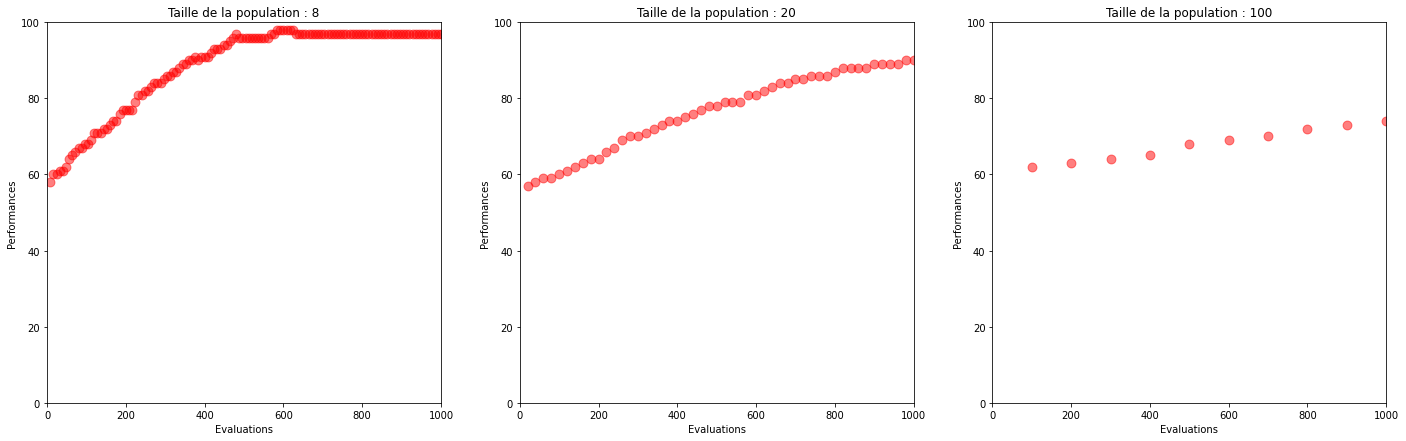

In [8]:
# paramètres 
evaluations = 1000
tailleInd = 100
taillePop = [8, 20, 100]
tailleTournoi = 8
Pmutation = 1./tailleInd
verbose = False

# initialisation des individus de la population initiale

population = []
for i in range(taillePop[2]):
    individu = []
    for j in range(tailleInd):
        individu.append( randint(0,1) )
    population.append([individu,0]) # N * [ genome[] , fitness ]



data = []
fitness = []
iterationMin = []

for n in range(len(taillePop)):

  # exécute l'algorithme génétique pour trois tailles de populations distinctes [8, 20, 100]
  retValue = evolve(sample(population,taillePop[n]),evaluations,taillePop[n],evaluate_oneMaxProblem,selectTournament,mutateBitFlip,Pmutation,verbose)
  data.append( retValue[0] )
  fitness.append( retValue[1][1] )
  iterationMin.append( retValue[2] )

  # affichage des résultats 
  print ("Taille de la population :", taillePop[n], " Meilleure fitness    :", retValue[1][1], " trouvé à l'itération :", retValue[2])

# affichage des performances
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize=(24,7), gridspec_kw={'width_ratios': [1, 1, 1]})
ax1.set_title('Taille de la population : 8')
plotIndividuals(ax1,data[0],0,evaluations,0,tailleInd)
ax2.set_title('Taille de la population : 20')
plotIndividuals(ax2,data[1],0,evaluations,0,tailleInd)
ax3.set_title('Taille de la population : 100')
plotIndividuals(ax3,data[2],0,evaluations,0,tailleInd)


**Objectif :**

On décide d'étudier l'algorithme pour trois tailles de populations distinctes : 8, 20 et 100. Choix arbitraire, mais où l'un est la taille d'étude pour la sélection K-tournament et les autres resp. le double de la taille de la population initiale et le dixième des évaluations.

***Remarque :***
Etant donné que l'on essaie de comparer les résultats, nous tenons compte du fait que si on devait utiliser trois fois l'exemple introductif, on aurait trois populations totalement distinctes et de taille différente. On essaie donc de réduire l'influence stochastique de la population de départ, en créant une grande population (de taille 100) et en piochant aléatoirement dedans pour créer nos populations de taille n=[8,20,100]. A noter qu'en faisant cela, il se peut que les meilleurs individus de la population de grande taille ne soient pas contenus dans celles étudiées.

**Analyse des résultats :**

On trace la performance après que la génération se soit déroulée, on observe donc à chaque fois x points, correspondant aux 1000 évaluations divisé par la taille de la population. Plus la taille de la population est grande (ou le nombre d'évaluation élevé), plus la courbe sera dense et la qualité des résultats élevée. 

D'après les graphiques, lorsque la taille de la population est trop élevée pour pas assez d'évaluations (voir Fig.3), les nouvelles populations prennent "trop de temps" à se former sur le long terme. Le caractère aléatoire des mutations (et de la sélection, significatif dans le cas d'un opérateur K-tournament) n'impacte pas assez les individus, pour converger vers le génome idéal (max-one). Au contraire, lorsque la taille de la population est faible, l'algorithme tourne plus de fois, laissant apparaitre plus de mutation bénéfiques.

D'un point de vu performance, la meilleure fitness est atteinte plus rapidement dans le temps lorsque la population est plus réduite. De plus, lorsque la taille de la population est trop élevée et/ou le temps d'étude trop réduit, la performance augmente moins vite (allure de la courbe).





---


# Exercice 2

Etudiez le comportement de l'algorithme lorsque l'on change le taux de mutation. 

Affichez les résultats pour trois paramètrages "typiques" (uniquement le graphe et la valeur du meilleur individu, comme ci-dessus).

Qu'en concluez-vous?


Taux de mutation : 0.001  Meilleure fitness    : 81  trouvé à l'itération : 970
Taux de mutation : 0.01  Meilleure fitness    : 98  trouvé à l'itération : 990
Taux de mutation : 0.1  Meilleure fitness    : 80  trouvé à l'itération : 840
Taux de mutation : 0.5  Meilleure fitness    : 64  trouvé à l'itération : 60


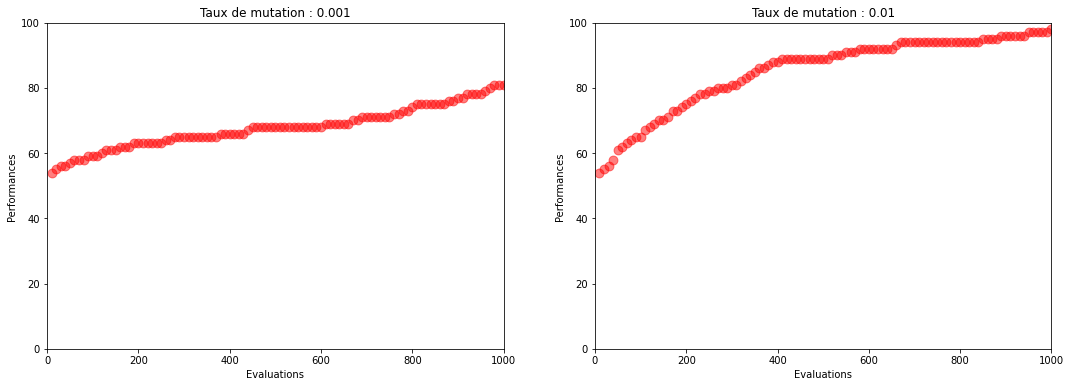

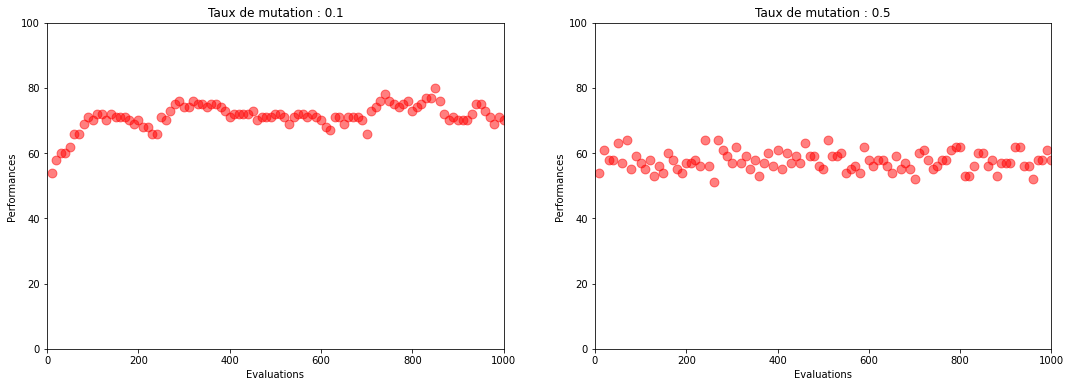

In [9]:
# paramètres - Attention aux précédentes modifications
taillePop = 10
pMutation = [0.001, 0.01, 0.1, 0.5]

# initialisation des individus de la population initiale
population = []
for i in range(taillePop):
    individu = []
    for j in range(tailleInd):
        individu.append( randint(0,1) )
    population.append([individu,0]) # N * [ genome[] , fitness ]

data = []
fitness = []
iterationMin = []

for n in range(len(pMutation)):

  # exécute l'algorithme génétique pour une population de 10 génomes, et de trois taux de mutation distincts [0.001, 0.01, 0.1, 0.5]
  retValue = evolve(population,evaluations,taillePop,evaluate_oneMaxProblem,selectTournament,mutateBitFlip,pMutation[n],verbose)
  data.append( retValue[0] )
  fitness.append( retValue[1][1] )
  iterationMin.append( retValue[2] )

  # affichage des résultats 
  print ("Taux de mutation :", pMutation[n], " Meilleure fitness    :", retValue[1][1], " trouvé à l'itération :", retValue[2])

# affichage des performances
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(18,6), gridspec_kw={'width_ratios': [1, 1]})
ax1.set_title('Taux de mutation : 0.001')
plotIndividuals(ax1,data[0],0,evaluations,0,tailleInd)
ax2.set_title('Taux de mutation : 0.01')
plotIndividuals(ax2,data[1],0,evaluations,0,tailleInd)

fig, (ax3, ax4) = plt.subplots(nrows = 1, ncols = 2, figsize=(18,6), gridspec_kw={'width_ratios': [1, 1]})
ax3.set_title('Taux de mutation : 0.1')
plotIndividuals(ax3,data[2],0,evaluations,0,tailleInd)
ax4.set_title('Taux de mutation : 0.5')
plotIndividuals(ax4,data[3],0,evaluations,0,tailleInd)

**Objectif :**

On décide d'étudier l'algorithme pour quatre taux de mutation distinctes : 0.001, 0.01, 0.1 et 0.5. Le taux de mutation est la probabilité **fixe** que l'un des bits du génome s'inverse (A noter que pour certains algorithme génétique, on pourrait trouver un taux auto-adaptatif au cours du temps), lorsque l'on passe d'un individu parent à un individu enfant pour créer la nouvelle population. Donc, une probabilité faible signifie que le génome parent vers enfant va quasiment rester le même, au contraire d'une probabilité forte qui changera pratiquement le génome en entier

**Analyse des résultats :**

Le taux de mutation est un des paramètres influents de l'algorithme génétique que l'on chercher à optimiser (voir Question 6), pour augmenter la performance et la rapidité. D'après les graphiques ci-dessus, on remarque que plus le taux de mutation est faible, plus l'évolution de la performance sera lente (voir Fig.1). Pour un tel schéma, cela signifie que les individus, dits enfants, à chaque nouvelle population seront trop identiques aux générations précédentes. L'apparition des individus les plus adaptés (fittest) se fera beaucoup plus lentement (progressivement) qu'avec un taux de mutation plus élevé. 

Au contraire, si la mutation est trop forte, on détruit l'action de notre opérateur de sélection (voir Fig.3-4). En effet bien que l'on sélectionne les meilleurs individus, avec un fort taux de mutation, on crée des enfants trop différents des parents, ce qui n'a plus de sens. 

En conclusion, le choix d'un taux de mutation d'environ 1% (ici, probabilité = 1/nombre de bits) semble le plus adapté et amène une meilleure performance et le plus rapidement. 

---



---

In [ ]:
#
# Boucle principale de l'algorithme génétique (nouvelle version)
#
# Version 1.2 : ajout d'un opérateur de sélection élitiste (mu,lamda)
# Version 1.3 : ajout d'un opérateur de croisement one-point crossover

def evolveES(pop, evals, taillePop, evaluate,select, tailleSelect, crossover, pCrossover, mutate, pMutation, verbose):
  it = 0
  nbGen = 0
  data = []

  meilleurIndividuDepuisToujours = [[],0]

  while it + taillePop <= evals:

      if verbose == True:
          print ("# Generation", nbGen,":",)

      # évalue les individus
      for individu in pop:
          individu[1] = evaluate(individu[0])

      # mémorise le meilleur de la génération
      meilleurIndividu = returnBestIndividual(pop)
      data.append([it+taillePop,meilleurIndividu[1]])

      # met à jour, si nécessaire, le meilleur individu depuis le début
      if meilleurIndividu[1] > meilleurIndividuDepuisToujours[1]:
        meilleurIndividuDepuisToujours = meilleurIndividu[:]
        meilleurIteration = it # donne l'itération correspondant au début de la génération courante.

      if verbose == True:
        print ("\tMeilleur individu courant:",meilleurIndividu[0]," -- fitness:",meilleurIndividu[1])

      # construit une nouvelle population
      nouvellePopulation = []

      for i in range(taillePop): 

          # sélectionne les mu meilleurs individus de la population précédente
          parents = select(pop, tailleSelect)

          if mu == 1 :
            nouvelIndividu = mutate(parents[0],pMutation)
            nouvellePopulation.append([nouvelIndividu,0])
          else :
            # mu supérieur ou égal à 2 dans le cas d'un algorithme avec croisement
            # sélectionne au hasard 2 parents pour générer lambda enfants
            if len(parents) == 1:
              parent1 = parents[0]
              parent2 = parents[0]            
            elif len(parents) == 2:
              parent1 = parents[0]
              parent2 = parents[1]
            else :
              while True:
                parent1 = choice(parents)
                parent2 = choice(parents)
                if not parent1 == parent2:
                  break # parent1 et parent2 doit être différement dans le cas d'un croisement pour générer lambda enfants

            # croisement de deux parents pour former deux enfants
            enfants = crossover(parent1, parent2, pCrossover, nbrEnfant = 1) # renvoie un enfant issue du croisement de deux parents

            # crée un nouvel individu par mutation après sélection et croisement, et l'ajoute à la nouvelle population
            for j in range(len(enfants)):
              nouvelIndividu = mutate(enfants[j],pMutation)
              nouvellePopulation.append([nouvelIndividu,0])

          # si le résultat du croisement est de 2 enfants, on diminue le nombre d'évaluation pour former la nouvelle population
          if len(nouvellePopulation) > (i+1):
            i = len(nouvellePopulation)

      # passe a la génération suivante
      pop = nouvellePopulation[:]

      it = it + taillePop
      nbGen += 1

  return (data,meilleurIndividuDepuisToujours,meilleurIteration)

print(date.today(), datetime.now().strftime("%H:%M:%S"),"GMT") # timestamp is greenwich time
print("OK.")

2020-12-29 09:05:12 GMT
OK.




---



---


# Exercice 3

Implémentez un opérateur de sélection (mu,lambda). Testez-le avec
* mu = taillePopulation / 2
* mu = 1

Affichez les résultats pour ces deux paramètrages, ainsi que pour un troisième dont vous pouvez choisir la valeur.

Qu'en concluez-vous?


In [10]:
# renvoie mu individus sélectionnés selon une méthode élitiste (fittest)
def selectElitism(pop, mu):
    parents = []  

    # sélectionne les mu meilleurs individus parmi la population
    for i in range(mu):
      parents.append( pop[ sorted(list(range(len(pop))), key=lambda x:pop[x][1])[-1-i] ][0] )

    return parents

# def withoutCrossover()

In [ ]:
# paramètres 
evaluations = 1000
tailleInd = 100
taillePop = 10
mu = [1, int(taillePop/2), int(taillePop)]
pCrossover = 0
pMutation = 1./tailleInd
verbose = False

# initialisation des individus de la population initiale
population = []
for i in range(taillePop):
    individu = []
    for j in range(tailleInd):
        individu.append( randint(0,1) )
    population.append([individu,0]) # N * [ genome[] , fitness ]

data = []
fitness = []
iterationMin = []

for n in range(len(mu)):

  # exécute l'algorithme génétique version 1.2 (pCrossover = 0), pour trois mu différents [1, 5, 10]
  retValue = evolveES(population,evaluations,taillePop,evaluate_oneMaxProblem,selectElitism,mu[n],onePointCrossover,pCrossover,mutateBitFlip,pMutation,verbose)
  data.append( retValue[0] )
  fitness.append( retValue[1][1] )
  iterationMin.append( retValue[2] )

  # affichage des résultats 
  print ("Taille de la sélection élitiste :", mu[n], " Meilleure fitness :", retValue[1][1], " trouvé à l'itération :", retValue[2])

# affichage des performances
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize=(24,7), gridspec_kw={'width_ratios': [1, 1, 1]})
ax1.set_title('(mu=1, lambda=1)-ES')
plotIndividuals(ax1,data[0],0,evaluations,0,tailleInd)
ax2.set_title('(mu=5, lambda=1)-ES')
plotIndividuals(ax2,data[1],0,evaluations,0,tailleInd)
ax3.set_title('(mu=10, lambda=1)-ES')
plotIndividuals(ax3,data[2],0,evaluations,0,tailleInd)

NameError: name 'randint' is not defined

**Objectif :**

On décide d'utiliser cette fois-ci un opérateur de sélection *(mu, lambda)-ES*, dit élitiste, qui sélectionne mu parents parmi la population pour générer lambda enfants aléatoirement. Dans notre cas, l'opérateur renvoie un tableau *parents* contenant mu individus (les meilleurs). Par la suite, la boucle principale sélectionne aléatoirement deux individus pour les croiser (voir Question 4) et/ou les muter. Dans la logique, on considère que si mu=1, c'est qu'on souhaite générer seulement un nouvel individu dans la nouvelle population après phase de sélection (et de mutation). Dans ce cas, on n'utilise aucun opérateur de croisement, car ce serait inutile de croiser un génome avec lui-même. 

Dans les tests effectués ci-dessus, on ne considère pour le moment pas d'opérateur de croisement, seulement une sélection aléatoirement d'un individu parmi les mu meilleurs parents. Comme dans l'exemple initial, on génère à chaque nouvelle génération/population, chaque individu un par un. 

**Analyse des résultats :**

D'après les performances, on constate parfaitement que si augmente la sélection élistite, on augmente l'effet stochastique du choix de l'individu couplé à celui de la mutation et on perd donc la fitness des meilleurs individus sélectionnés. 

Dans le cas mu=1, on sélectionne à chaque fois LE meilleur individu de la population que l'on fais muté n fois pour créer une nouvelle population. Ainsi, on garde une base de génome performante que l'on fais mutée aléatoirement, pour faire apparaitre un nouveau génome plus performant que l'on sélectionnera à la prochaine génération.

Dans le cas mu=5, la taille de la sélection est plus grande et rien ne garantie de sélectionner le meilleur individu de la population. La convergence vers le génome *fittest* sera plus longue et nécessitera plus d'évaluation (augmentation du budget).

Dans le cas mu=10 (taille de la population), on détruit l'opérateur de sélection élitiste par la sélection stochastique du parent à muter. On voit sur la figure que la performance n'évolue plus du tout à travers les générations car on ne garde plus les individus les plus adapté.

En conclusion, il est plus adapté de sélectionner mu=1 ou mu=2, si l'on souhaite par la suite effectué un croisement entre donc les deux meilleurs parents.




---


# Exercice 4

Implémenter un opérateur de croisement "one-point crossover", qui s'applique avec un taux de croisement Pcrossover à définir. Cet opérateur construit un nouvel individu à partir de deux individus parents.

Testez cet opérateur en mettant le taux de mutation à zéro, et en utilisant l'opérateur de sélection implémenté à la question précédente, avec mu=1.

Affichez le meilleur résultat que vous aurez pu trouver.

Qu'en concluez-vous?


In [ ]:
# renvoie une copie mutée à partir de deux individus parents passés en paramètre, selon la méthode de mutation "one-point-crossover"
def onePointCrossover(parent1, parent2, pCrossover, nbrEnfant):

    # point de séparation aléatoire du génome des deux parents : 'crossover point'
    rdmCrossoverPoint = randrange(1,len(parent1))
    enfant1 = []
    enfant2 = []

    # croisement effectué avec un taux pCrossover de 70%
    if random() < pCrossover:
      enfant1 = list(np.append(parent1[:rdmCrossoverPoint], parent2[rdmCrossoverPoint:]))
      enfant2 = list(np.append(parent2[:rdmCrossoverPoint], parent1[rdmCrossoverPoint:]))
    else:
      # si aucun croisement, on garde le génome des parents
      enfant1 = parent1
      enfant2 = parent2

    # renvoie lambda (ici, lambda=1) enfants à générer
    if nbrEnfant == 1:
      enfants = sample([enfant1, enfant2],1) # si lambda=1, on renvoit aléatoirement l'un des deux enfants possèdant chacun une partie du génome des parents
    else:
      enfants = [enfant1, enfant2]

    return enfants

Meilleure genome     : [1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
Meilleure fitness    : 61
trouvé à l'itération : 10


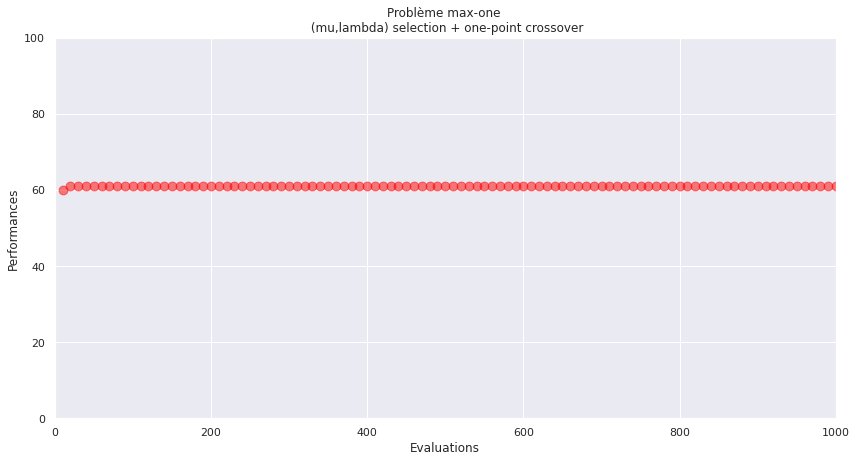

In [ ]:
# paramètres 

mu = 2 # sélectionne deux individus (ici les meilleurs) à croiser
pCrossover = 0.7
pMutation = 0.0 # l'évolution des génération s'effectue seulement par croisement

# exécute l'algorithme génétique version 1.3 (pCrossover = 0.7)
retValue = evolveES(population,evaluations,taillePop,evaluate_oneMaxProblem,selectElitism,mu,onePointCrossover,pCrossover,mutateBitFlip,pMutation,verbose)

data = retValue[0]
fitness = retValue[1][1]
iterationMin = retValue[2]

# affichage des résultats 
print ("Meilleure genome     :", retValue[1][0])
print ("Meilleure fitness    :", fitness)
print ("trouvé à l'itération :", iterationMin)

# affichage des performances
fig, ax = plt.subplots(figsize=(14,7))
ax.set_title('Problème max-one \n (mu,lambda) selection + one-point crossover') 
plotIndividuals(ax,data,0,evaluations,0,tailleInd)

**Objectif :**

On décide d'ajouter cette fois-ci un opérateur de croisement, dit *One-point crossover*, à l'algorithme. Cet opérateur croise deux individus parents en un point de croisement aléatoire, en mélangeant une partie du génome de l'un avec la partie opposé de l'autre individu. Le croisement est orienté exploration, et permet de visiter des combinaisons non-explorées à la recherche de bons individus. L'idée ici est d'étudier l'influence d'une population soumise à des croisements sous mutation et avec une sélection élitiste.

**Remarque :** Logiquement l'utilisation d'un opérateur de sélection doit nécessairement renvoyer deux individus distincts (mu >= 2) pour que le croisement se fasse. Dans cet algorithme, la compréhension personnelle de la consigne a impliqué que l'on utilise l'opérateur de sélection m=2 avec lambda=1. Par ailleurs, en général un croisement implique de créer deux enfants à partir de deux parents, mais pour mieux comparer la rapidité de l'algorithme, l'opérateur de croisement renvoie aléatoirement un des deux enfants issus du croisement.

**Analyse des résultats :**

D'après le graphique, la performance converge vers une valeur très faible très rapidement. En effet, puisque l'on sélectionne les deux meilleurs individus de la population que l'on croise en un point aléatoire, toutes les combinaisons du génome sont très vites calculées. Les limites de la performance maximale sont donc très rapidement atteintes.

En conclusion, il est évident que l'utilisation seule d'un opérateur de croisement sans mutation est inutile (et loin de la réalité) pour assurer une évolution génétique au sein d'une population sur le long terme.

---
# Exercice 5

On vous demande maintenant de définir et d'utiliser une nouvelle fonction fitness. Il s'agit cette fois de découvrir une séquence de nucléotides cible, à savoir *ATATCGGAGAGGGCCTAGATCACATGATACA* (il s'agit d'une séquence arbitraire). 

L'espace de recherche est donc celui des séquences de caractères, dont chaque caractère prend une valeur A, T, C ou G. 

La fonction objectif renvoie la distance de hamming entre la séquence cible et la séquence courante. Le score pour chaque nucléotide est de 1 (si les deux motifs sont identiques) ou 0 (dans tous les autres cas). 

Implémentez cette fonction fitness, et modifiez les opérateurs de mutation et de croisement utilisés jusqu'ici pour fonctionner avec ce nouveau génome.

Qu'en concluez-vous?


In [ ]:
# renvoie la fitness d'une séquence de nucléiques pour une séquence cible
def evaluate_HammingDistance(sequence):
    cible = ['A','A','T','C','G','G','A','G','A','G','G','G','C','C','T','A','G','A','T','C','A','C','A','T','G','A','T','A','C','A']
    # Start with a fitness of zero, and count up
    fitness = 0
    for i in range(len(sequence)):
        if sequence[i] == cible[i]:
            # Add 1 to the distance if these two characters are equal
            fitness += 1
    return fitness

# renvoie une copie mutée de l'individu passé en paramètre, selon la méthode de mutation "bit-flip"
def mutateTransitionTransversion(sequence,pMutation):
    nucleiques = ['A','T','C','G']
    nouvelleSequence = []
    for e in sequence:
        if random() < pMutation:
            nouvelleSequence.append( choice(nucleiques) )
        else:
            nouvelleSequence.append( e )
    return nouvelleSequence

print(date.today(), datetime.now().strftime("%H:%M:%S"),"GMT") # timestamp is greenwich time
print("OK.")

2020-12-29 08:51:37 GMT
OK.


Meilleure genome     : ['A', 'A', 'T', 'C', 'G', 'G', 'A', 'G', 'A', 'G', 'G', 'G', 'C', 'C', 'T', 'A', 'G', 'A', 'T', 'C', 'A', 'C', 'A', 'T', 'G', 'A', 'T', 'A', 'C', 'A']
Meilleure fitness    : 30
trouvé à l'itération : 690


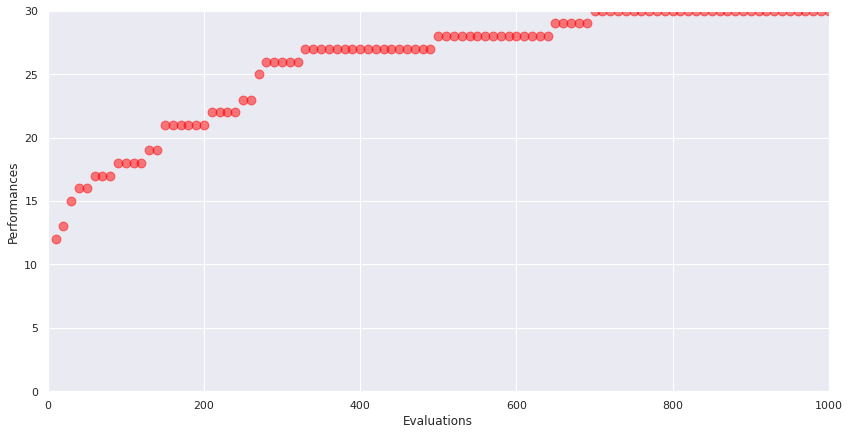

In [ ]:
# paramètres 
nucleiques = ['A','T','C','G']
cible = ['A','A','T','C','G','G','A','G','A','G','G','G','C','C','T','A','G','A','T','C','A','C','A','T','G','A','T','A','C','A']
evaluations = 1000
tailleSequence = len(cible)
tailleADN = 10
mu = 2  #int(taillePop/2)
pCrossover = 0.7
pMutation = 1./tailleSequence
verbose = False

ADN = []
for i in range(tailleADN):
    sequence = []
    for j in range(tailleSequence):
        sequence.append( choice(nucleiques) )
    ADN.append([sequence,0]) # N * [ sequence[] , fitness ]

# exécute l'algorithme génétique version 1.3 (pCrossover = 0.7)
retValue = evolveES(ADN,evaluations,tailleADN,evaluate_HammingDistance,selectElitism,mu,onePointCrossover,pCrossover,mutateTransitionTransversion,pMutation,verbose)

# affichage des résultats 
fig, ax = plt.subplots(figsize=(14,7))
plotIndividuals(ax,retValue[0],0,evaluations,0,tailleSequence)
print ("Meilleure genome     :", retValue[1][0])
print ("Meilleure fitness    :", retValue[1][1])
print ("trouvé à l'itération :", retValue[2])

**Objectifs :**

On décide cette fois-ci d'utiliser l'algorithme génétique pour découvrir une séquence de nucléotides cible, donnée ci-dessus. Cet exemple pourrait se rapprocher d'une étude pratique d'une séquence d'ADN, composé de bases azotées **adénine (A), guanine (G), cytosine (C) et thymine (T)**, à reproduire sur le temps via mutation et/ou croisement.

L'algorithme se déroule comme pour le problème du Max-one : Population de base générée aléatoirement, Évaluation, Sélection, Croisement et Mutation. L'opérateur de sélection et de croisement sont les mêmes que dans l'exemple précédent : une sélection (mu, lambda), dit élitiste, et un croisement à un point. L'opérateur de mutation est adapté au problème sous la forme d'un *Bitflip* (substitution), cad que chaque base du brin peut être substituée par l'une des trois autres bases. 

En pratique, en chimie organique, les fréquences de subsitution dans le génome (de James Watson) dépendent du type de la base azoté et du sens. On classe les bases azotées en 2 familles: les purines (A et G) et les pyrimidines (C et T).
Il existe deux types de substitutions nucléotidiques : la **transition**, subsitution entre deux bases sans changement de famille, et la **transversion**, associé à un changement de famille. Si les mutations sont aléatoires nous devons, en pratique, observer 2 fois plus de transversions que de transitions. Par conséquent, il aurait été plus adapté d'utiliser deux taux de mutation, noté alpha et beta, en fonction du sens de la subsitution. 

**Analyse des résultats :**

La taille du brin d'ADN étant plus petite, la convergence de la performance est plus rapide que dans les exemples précédents. Néanmoins, la non-binarité des mutations augmente l'effet stochastique sur les nouvelles populations, avec un risque de perdre les bonnes séquences. 

Ici, on calcule la performance de la séquence par la distance de Hamming, qui quantifie la différence entre deux séquences de symboles (distance au sens mathématique). La notion de fitness est associé au **poids de Hamming**, correspondant au nombre d'éléments différents de zéro dans la chaîne d'éléments.

Par ailleurs, l'effet stochastique de la population de départ est renforcé par la compléxité non plus binaire, des nucléotides. Ceci a pour effet de diminuer la qualité des résultats en terme de rapidité, car les résultats sont très différents entre plusieurs runs (méthode stochastique). Une solution est donc de lancer plusieurs runs, en traçant les résultats pour analyser les performances de l'algorithme et des paramètrès, via des graphiques Boxplot (boite à moustache) en comparant la médiane (voir Question 6). 

---

# Exercice 6

On a jusqu'ici observé les résultats d'une seule exécution de l'algorithme pour chaque jeu de paramètres. Les algorithmes évolutionnaires sont par essence stochastique, et *il est important de systématiquement plusieurs runs indépendants pour un même jeu de paramètres*. C'est en compilant ces résultats qu'on obtient une bonne estimation de la qualité de notre algorithme et des paramètres utilisés. 

Pour l'instant, vous avez comparé *empiriquement* la forme des courbes et vous avez basé vos conclusions sur l'itération à laquelle le meilleur individu a été découvert et sa valeur de fitness, en lançant plusieurs expérience.

On souhaite maintenant synthétiser en un seul graphique les performances obtenues sur plusieurs exécutions indépendantes avec les mêmes paramètres.

En vous inspirant du code ci-dessous, compilez les résultats de 20 exécutions indépendantes en utilisant les paramètres initialement donnés dans l'exemple initial.

Faites la même chose en utilisant la version écrite pour la question 3, avec mu=1, d'abord avec le taux de mutation initial. Ensuite, essayer de trouver le "meilleur" taux de mutation pour trouver la solution plus rapidement.

Tracez les trois graphes obtenus.

Commentez vos résultats.


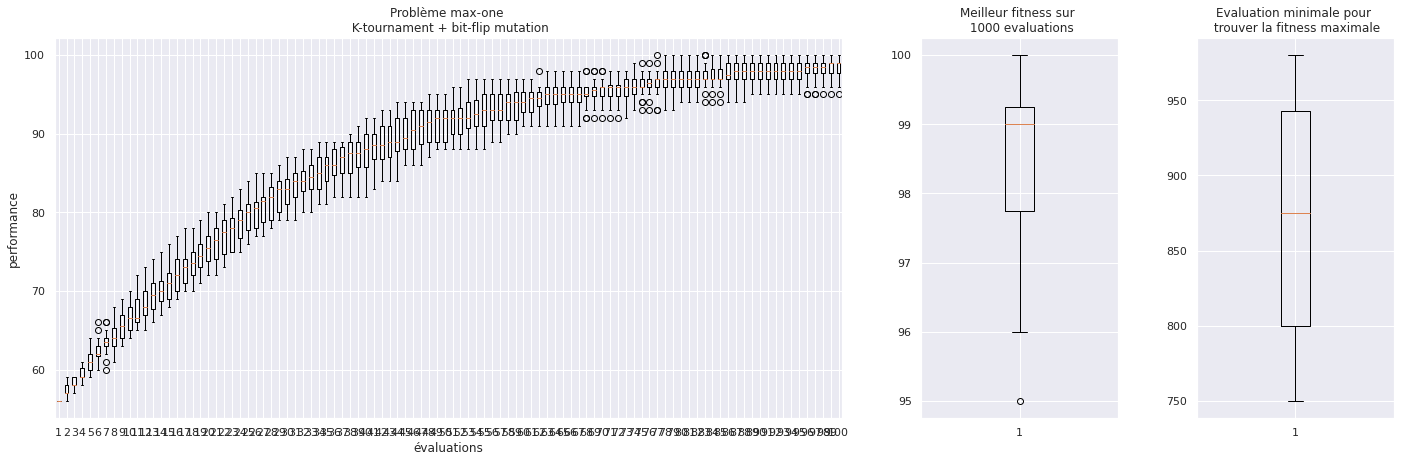

In [ ]:
# paramètres 

evaluations = 1000
tailleInd = 100
taillePop = 10
tailleTournoi = 8
Pmutation = 1./tailleInd
verbose = False

# initialisation des individus de la population initiale

population = []
for i in range(taillePop):
    individu = []
    for j in range(tailleInd):
        individu.append( randint(0,1) )
    population.append([individu,0]) # N * [ genome[] , fitness ]

data = []
fitness = []
iterationMin = []

for n in range(20):

  # exécute l'algorithme génétique n fois
  retValue = evolve(population,evaluations,taillePop,evaluate_oneMaxProblem,selectTournament,mutateBitFlip,Pmutation,verbose)

  data.append( list( np.array( retValue[0] )[:,1] ) )
  fitness.append( retValue[1][1] )
  iterationMin.append( retValue[2] )

  # affichage des résultats 
  #print ("Execution n =", n+1, " Meilleure fitness    :", retValue[1][1], " trouvé à l'itération :", retValue[2])

data = np.array(data)

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize=(24,7), gridspec_kw={'width_ratios': [4, 1, 1]})

ax1.set_title('Problème max-one \n K-tournament + bit-flip mutation')
ax1.boxplot(data)
ax1.set_xlabel('évaluations')
ax1.set_ylabel('performance')

ax2.set_title('Meilleur fitness sur \n 1000 evaluations')
ax2.boxplot(fitness)

ax3.set_title('Evaluation minimale pour \n trouver la fitness maximale')
ax3.boxplot(iterationMin)

plt.show()

**Objectifs :**

On décide d'analyser les performances de notre algorithme génétique par une série de plusieurs tests sur une même population de départ. Les résultats performances pour chaque test sont donc tracés sous forme de Boxplot à chaque évaluation. Si l'on s'intéresse à la médiane, on peut ainsi conclure de la performance type de l'algorithme sur plusieurs runs.

Dans un second temps, on s'intéresse plus particuilèrement à la performance et à la rapidité de l'algorithme et des paramètres choisis. Les deux derniers graphiques tracent respectivement la performance du meilleur individu sur toutes les générations et l'évaluation minimale à laquelle la fitness est maximale.

**Analyse des résultats :**

L'interprétation de boxplot permet d'en savoir plus sur le centrage et la dispersion des données d'échantillon. Si l'on s'intéresse qu'aux meilleurs individus, on remarque que la médiane si situe à une performance de 99, ce qui implique en général 1% d'erreur dans le génome. Quant à la rapidité, celle-ci se situe entre 850 et 900 itérations. Un boxplot permet également de relever des indicateurs de données non normales ou aberrantes, signe d'une erreur de mesure ou de rentrée de données (exemple, point à 95 pour la performance). L'asymétrie indique également que les données peuvent ne pas être normalement distribuées, comme pour le fitness par exemple. En général, augmenter le nombre de runs d'étude permet de corriger lasymétrie et vérifier que ce n'était pas un problème de données.

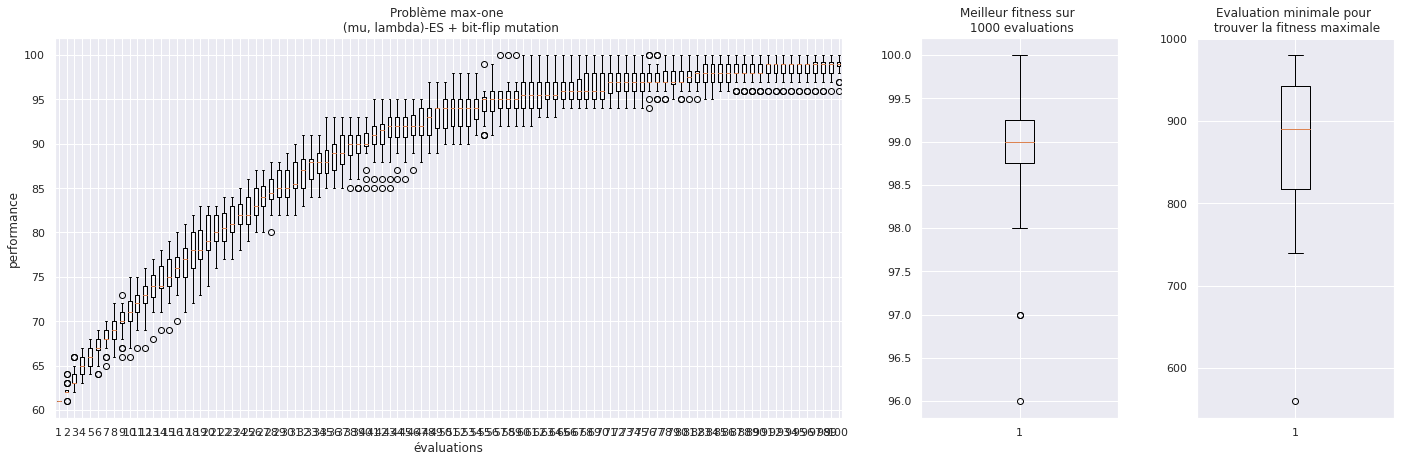

In [ ]:
# paramètres 
evaluations = 1000
tailleInd = 100
taillePop = 10
mu = 1
pCrossover = 0
pMutation = 1./tailleInd
verbose = False

# initialisation des individus de la population initiale
population = []
for i in range(taillePop):
    individu = []
    for j in range(tailleInd):
        individu.append( randint(0,1) )
    population.append([individu,0]) # N * [ genome[] , fitness ]

data = []
fitness = []
iterationMin = []

for n in range(20):

  # exécute l'algorithme génétique (version 1.2) n fois
  retValue = evolveES(population,evaluations,taillePop,evaluate_oneMaxProblem,selectElitism,mu,onePointCrossover,pCrossover,mutateBitFlip,pMutation,verbose)

  data.append( list( np.array( retValue[0] )[:,1] ) )
  fitness.append( retValue[1][1] )
  iterationMin.append( retValue[2] )

  # affichage des résultats 
  #print ("Execution n =", n+1, " Meilleure fitness    :", retValue[1][1], " trouvé à l'itération :", retValue[2])

data = np.array(data)

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize=(24,7), gridspec_kw={'width_ratios': [4, 1, 1]})

ax1.set_title('Problème max-one \n (mu, lambda)-ES + bit-flip mutation')
ax1.boxplot(data)
ax1.set_xlabel('évaluations')
ax1.set_ylabel('performance')
ax2.set_title('Meilleur fitness sur \n 1000 evaluations')
ax2.boxplot(fitness)
ax3.set_title('Evaluation minimale pour \n trouver la fitness maximale')
ax3.boxplot(iterationMin)

plt.show()

**Commentaires :**

L'analyse est la même que précédemment, le but est de vérifier la rapidité, la performance et l'évolution de celle-ci de manière statistique. Par ailleurs, en comparaison avec l'exemple initial, l'algorithme avec un opérateur de sélection élitiste sembe contenir et/ou générer plus de données aberrantes et d'asymétrie dans les résultats.

Meilleurs résultats obtenus pour un taux de mutation :  0.013
Fitness maximal : 99.0 obtenu pour un minimum de  875.0 évaluations.
(Résultats obtenus après interprétation statistique de  50 runs)


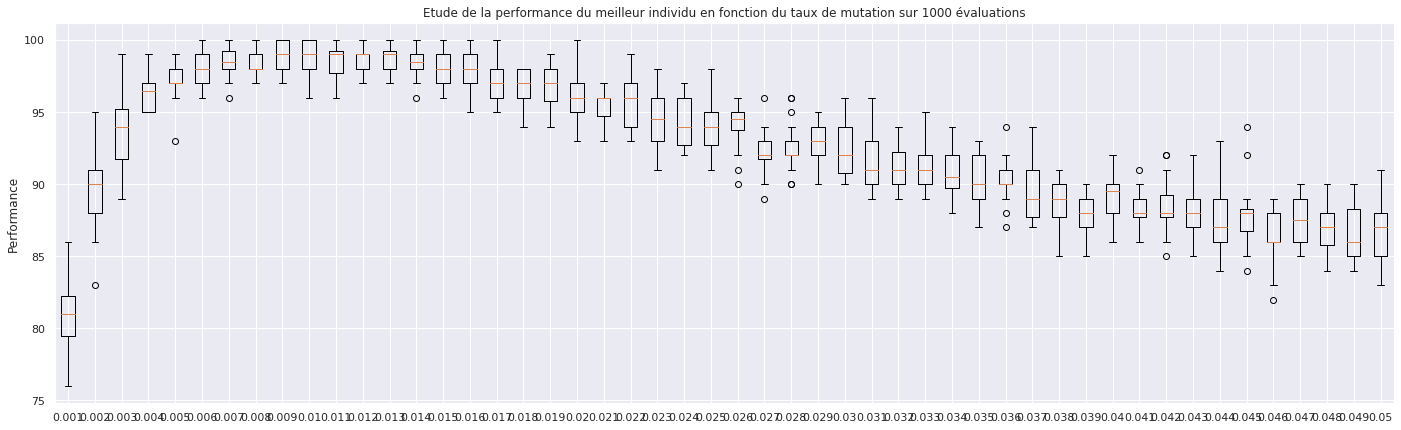

In [ ]:
# paramètres 
evaluations = 1000
tailleInd = 100
taillePop = 10
mu = 1
pCrossover = 0
pMutation = np.arange(0.001,0.031,0.001)
verbose = False

# initialisation des individus de la population initiale
population = []
for i in range(taillePop):
    individu = []
    for j in range(tailleInd):
        individu.append( randint(0,1) )
    population.append([individu,0]) # N * [ genome[] , fitness ]

meilleurEvaluation = [0,evaluations,0]
data = []
meilleursFitness = []
fitness = []
iterationMin = []

for k in range(len(pMutation)):

  data = []
  fitness = []
  iterationMin = []

  for n in range(20):

    # exécute l'algorithme génétique (version 1.2) n fois
    retValue = evolveES(population,evaluations,taillePop,evaluate_oneMaxProblem,selectElitism,mu,onePointCrossover,pCrossover,mutateBitFlip,pMutation[k],verbose)

    data.append( list( np.array( retValue[0] )[:,1] ) )
    fitness.append( retValue[1][1] )
    iterationMin.append( retValue[2] )

    # affichage des résultats 
    #print ("Execution n =", n+1, " Meilleure fitness    :", retValue[1][1], " trouvé à l'itération :", retValue[2])

  meilleursFitness.append(fitness)

  if meilleurEvaluation[1] > median(iterationMin) and median(fitness) >= 99:
    meilleurEvaluation[0] = pMutation[k]
    meilleurEvaluation[1] = median(iterationMin)
    meilleurEvaluation[2] = median(fitness)

print("Meilleurs résultats obtenus pour un taux de mutation : ", meilleurEvaluation[0].round(decimals=3))
print("Fitness maximal :", meilleurEvaluation[2], "obtenu pour un minimum de ", meilleurEvaluation[1], "évaluations.")
print("(Résultats obtenus après interprétation statistique de ", len(pMutation), "runs)")

fig, ax = plt.subplots(figsize=(24,7))
ax.set_title('Etude de la performance du meilleur individu en fonction du taux de mutation sur 1000 évaluations')
ax.boxplot(meilleursFitness, labels=pMutation.round(decimals=3))
ax.set_ylabel('Performance')  

plt.show()



**Objectifs :**

L'idée finale est d'optimiser le taux de mutation dans l'algorithme pour obtenir une performance optimale sur un nombre d'évaluation minimale. Le graphique ci-dessus permet de comparer la performance des meilleurs individus sur un échantillon n pour k taux de mutation. 

On décide d'interpréter les résultats via la notion de médiane (comme précédemment), tout en cherchant un compromis entre rapidité et performance. On accepte une performance relative minimale de 99%, et on cherche le taux de mutation idéale pour lequelle la rapidité est maximale.

**Analyse des résultats :**

Tracer les groupes d'étude pour différents taux de mutation permet d'évaluer et de comparer le centrage et la dispersion de ces derniers. L'indicateur de la médiane permet également de donner un premier aperçu de l'optimisation de l'algorithme.

Les résultats indiquent donc que le taux de mutation optimale est de 1,3%, pour une performance relative de 99% avec une rapidité relative de 875.0 évaluations. Ces informations sont à comparer avec la population de départ et les effets aléatoires de chaque runs.